In [80]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageOps,ImageDraw


def contar_caixas(imagem, subdivisoes, limiar=128, modo='preto'):
    """
    Aplica binarização e calcula o número de caixas contendo estrutura (ramificação)
    para cada subdivisão fornecida.

    Parâmetros:
        imagem: PIL.Image em tons de cinza
        subdivisoes: lista de inteiros com quantidades de blocos por lado (ex: [2, 4, 8, 16])
        limiar: valor de corte para binarização (0-255)
        modo: 'preto' conta pixels < limiar (estrutura), 'branco' conta pixels > limiar (fundo)

    Retorna:
        tam_caixa: lista com tamanhos das caixas (lado da imagem / subdivisão)
        num_caixas: lista com o número de blocos contendo estrutura
    """
    imagem = imagem.convert('L')  # Garante tons de cinza
    matriz = np.array(imagem)

    if modo == 'preto':
        binaria = np.where(matriz < limiar, 1, 0)
    else:
        binaria = np.where(matriz > limiar, 1, 0)

    largura, altura = imagem.size
    tam_caixa = []
    num_caixas = []

    cnt = 1
    for s in subdivisoes:
        print(cnt)
        cnt += 1
        box_w = largura // s
        box_h = altura // s
        count = 0
        for i in range(s):
            for j in range(s):
                bloco = binaria[j*box_h:(j+1)*box_h, i*box_w:(i+1)*box_w]
                if np.any(bloco):
                    count += 1
        tam_caixa.append(largura / s)
        num_caixas.append(count)

    return tam_caixa, num_caixas


def completar_quadrado(imagem):
    largura, altura = imagem.size
    lado = max(largura, altura)
    delta_larg = lado - largura
    delta_alt = lado - altura
    padding = (delta_larg // 2, delta_alt // 2, delta_larg - delta_larg // 2, delta_alt - delta_alt // 2)
    return ImageOps.expand(imagem, padding, fill=1)

In [81]:
caminho =  'image2.png'
imagem = Image.open(f"./imagens/{caminho}")
imagem = completar_quadrado(imagem)

In [40]:
imagem.size

(720, 720)

In [126]:
subdivs = np.geomspace(256,720, num=10, dtype=int)
limiar = 5  # Ajuste conforme contraste da imagem

# Chamada
tam_lados, num_blocos = contar_caixas(imagem, subdivs, limiar=limiar, modo='preto')


1
2
3
4
5
6
7
8
9
10


Dimensão fractal estimada: 1.8869


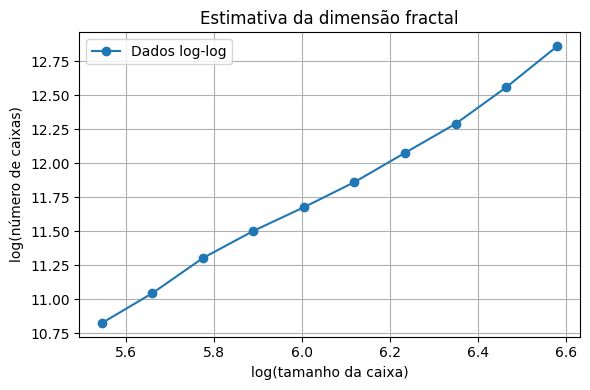

In [127]:

# Ajuste linear
log_inv_eps = np.log(subdivs) 
log_N = np.log(num_blocos)
coef, _ = np.polyfit(log_inv_eps, log_N, 1)
dim_fractal = coef

# Resultado
print(f"Dimensão fractal estimada: {dim_fractal:.4f}")

# Gráfico
plt.figure(figsize=(6, 4))
plt.plot(log_inv_eps, log_N, 'o-', label='Dados log-log')
plt.xlabel("log(tamanho da caixa)")
plt.ylabel("log(número de caixas)")
plt.title("Estimativa da dimensão fractal")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [128]:
coef_sem_intercepto = -np.sum(log_inv_eps * log_N) / np.sum(log_inv_eps ** 2)
coef_sem_intercepto

np.float64(-1.9466648597885663)

In [66]:
def desenhar_caixas_ativas(imagem, tamanho_caixa, limiar=128, modo='preto', cor=(255, 0, 0)):
    img_gray = imagem.convert('L')
    matriz = np.array(img_gray)

    if modo == 'preto':
        binaria = np.where(matriz < limiar, 1, 0)
    else:
        binaria = np.where(matriz > limiar, 1, 0)

    largura, altura = img_gray.size
    img_colorida = imagem.convert('RGB')
    draw = ImageDraw.Draw(img_colorida)

    for x in range(0, largura - tamanho_caixa + 1, tamanho_caixa):
        for y in range(0, altura - tamanho_caixa + 1, tamanho_caixa):
            bloco = binaria[y:y+tamanho_caixa, x:x+tamanho_caixa]
            if np.any(bloco):
                draw.rectangle([x, y, x + tamanho_caixa - 1, y + tamanho_caixa - 1], outline=cor, width=1)

    return img_colorida



In [74]:
from PIL import ImageEnhance

def preencher_caixas_ativas(imagem, tamanho_caixa, limiar=128, modo='preto', cor=(255, 0, 0, 128)):
    """
    Preenche as caixas que contêm estrutura com uma cor sólida (ou semitransparente).

    Parâmetros:
        imagem: PIL.Image em tons de cinza ou RGB
        tamanho_caixa: lado da caixa (em pixels)
        limiar: valor de corte para binarização
        modo: 'preto' (pixels < limiar) ou 'branco' (pixels > limiar)
        cor: tupla RGBA (ex: vermelho semitransparente = (255, 0, 0, 128))

    Retorna:
        imagem com sobreposição das caixas preenchidas
    """
    img_gray = imagem.convert('L')
    matriz = np.array(img_gray)

    if modo == 'preto':
        binaria = np.where(matriz < limiar, 1, 0)
    else:
        binaria = np.where(matriz > limiar, 1, 0)

    largura, altura = img_gray.size
    img_rgb = imagem.convert('RGBA')
    overlay = Image.new('RGBA', img_rgb.size, (0, 0, 0, 0))
    draw = ImageDraw.Draw(overlay)

    for x in range(0, largura - tamanho_caixa + 1, tamanho_caixa):
        for y in range(0, altura - tamanho_caixa + 1, tamanho_caixa):
            bloco = binaria[y:y+tamanho_caixa, x:x+tamanho_caixa]
            if np.any(bloco):
                draw.rectangle(
                    [x, y, x + tamanho_caixa - 1, y + tamanho_caixa - 1],
                    fill=cor
                )

    imagem_com_caixas = Image.alpha_composite(img_rgb, overlay)
    return imagem_com_caixas.convert('RGB')


In [75]:
tamanho = 10

# Gera a visualização
img_com_caixas = desenhar_caixas_ativas(imagem, tamanho_caixa=tamanho, limiar=20, modo='preto')

# Mostra a imagem
img_com_caixas.show()

In [91]:
tamanho = 2

# Gera a visualização
img_com_caixas = preencher_caixas_ativas(imagem, tamanho_caixa=tamanho, limiar=5, modo='branco')

# Mostra a imagem
img_com_caixas.show()

In [122]:
def dividir_em_blocos(imagem, tamanho):
    largura, altura = imagem.size
    blocos = [
        imagem.crop((x, y, x + tamanho, y + tamanho))
        for y in range(0, altura - tamanho + 1, tamanho)
        for x in range(0, largura - tamanho + 1, tamanho)
    ]
    return blocos

def contar_caixas_otimizado(imagem, subdivisoes, limiar=128, modo='preto'):
    """
    Versão otimizada da contagem de caixas usando PIL.Image.crop para dividir em blocos.

    Parâmetros:
        imagem: PIL.Image (de preferência binarizada ou tons de cinza)
        subdivisoes: lista com quantidades de blocos por lado (ex: [2, 4, 8, 16])
        limiar: valor de corte para decidir se um bloco contém estrutura
        modo: 'preto' para pixels < limiar, 'branco' para pixels > limiar

    Retorna:
        tam_caixa: lista com os tamanhos dos lados das caixas
        num_caixas: número de blocos com presença da estrutura
    """
    img_gray = imagem.convert('L')
    largura, altura = img_gray.size

    tam_caixa = []
    num_caixas = []
    cnt = 1
    for s in subdivisoes:
        print(cnt)
        cnt += 1
        tam = largura // s  # tamanho da caixa (assumindo imagem quadrada ou múltipla de s)
        blocos = dividir_em_blocos(img_gray, tam)
        count = 0
        for bloco in blocos:
            arr = np.array(bloco)
            if modo == 'preto':
                if np.any(arr < limiar):
                    count += 1
            else:
                if np.any(arr > limiar):
                    count += 1
        tam_caixa.append(tam)
        num_caixas.append(count)

    return tam_caixa, num_caixas


In [124]:
subdivs = np.geomspace(256,720, num=10, dtype=int)
limiar = 5  # Ajuste conforme contraste da imagem

# Chamada
tam_lados, num_blocos = contar_caixas_otimizado(imagem, subdivs, limiar=limiar, modo='preto')


1
2
3
4
5
6
7
8
9
10


Dimensão fractal estimada: 1.8869


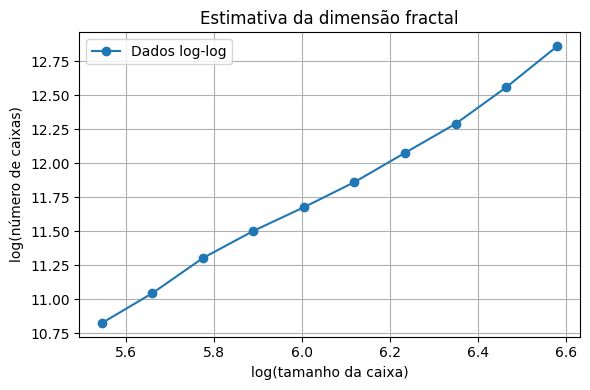

In [129]:
# Ajuste linear
log_inv_eps = np.log(subdivs) 
log_N = np.log(num_blocos)
coef, _ = np.polyfit(log_inv_eps, log_N, 1)
dim_fractal = coef

# Resultado
print(f"Dimensão fractal estimada: {dim_fractal:.4f}")

# Gráfico
plt.figure(figsize=(6, 4))
plt.plot(log_inv_eps, log_N, 'o-', label='Dados log-log')
plt.xlabel("log(tamanho da caixa)")
plt.ylabel("log(número de caixas)")
plt.title("Estimativa da dimensão fractal")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [131]:
def contar_caixas_numpy(imagem, subdivisoes, limiar=128, modo='preto'):
    """
    Contagem de caixas otimizada com NumPy puro.

    Parâmetros:
        imagem: PIL.Image em tons de cinza
        subdivisoes: lista de subdivisões do lado (ex: [2, 4, 8, 16])
        limiar: valor de corte
        modo: 'preto' ou 'branco'

    Retorna:
        tam_caixa: lista com tamanhos das caixas
        num_caixas: lista com número de caixas com estrutura
    """
    img_gray = imagem.convert('L')
    matriz = np.array(img_gray)
    altura, largura = matriz.shape

    tam_caixa = []
    num_caixas = []

    cnt = 1
    for s in subdivisoes:
        print(cnt)
        cnt += 1
        box_h = altura // s
        box_w = largura // s

        # Corta a imagem para múltiplo exato da caixa
        matriz_cortada = matriz[:box_h * s, :box_w * s]

        # Binarização
        if modo == 'preto':
            binaria = matriz_cortada < limiar
        else:
            binaria = matriz_cortada > limiar

        # Reshape para (s, box_h, s, box_w)
        reshaped = binaria.reshape(s, box_h, s, box_w)
        reshaped = reshaped.transpose(0, 2, 1, 3)  # (s, s, box_h, box_w)

        # Verifica se cada bloco tem algum pixel True
        presenca = np.any(reshaped, axis=(2, 3))
        count = np.sum(presenca)

        tam_caixa.append(largura / s)
        num_caixas.append(count)

    return tam_caixa, num_caixas


In [139]:
subdivs = np.geomspace(20,720, num=100, dtype=int)
limiar = 5  # Ajuste conforme contraste da imagem

# Chamada
tam_lados, num_blocos = contar_caixas_numpy(imagem, subdivs, limiar=limiar, modo='preto')

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100


Dimensão fractal estimada: 1.8768


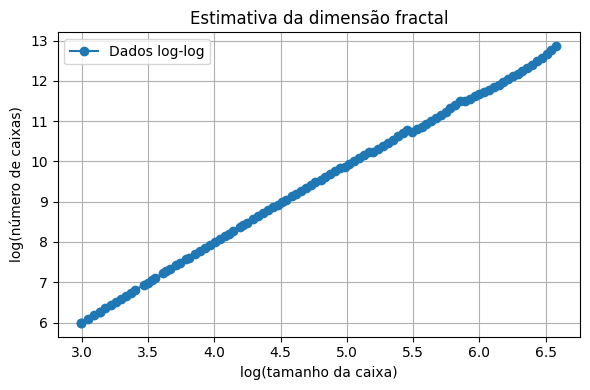

In [140]:
# Ajuste linear
log_inv_eps = np.log(subdivs) 
log_N = np.log(num_blocos)
coef, _ = np.polyfit(log_inv_eps, log_N, 1)
dim_fractal = coef

# Resultado
print(f"Dimensão fractal estimada: {dim_fractal:.4f}")

# Gráfico
plt.figure(figsize=(6, 4))
plt.plot(log_inv_eps, log_N, 'o-', label='Dados log-log')
plt.xlabel("log(tamanho da caixa)")
plt.ylabel("log(número de caixas)")
plt.title("Estimativa da dimensão fractal")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [141]:
coef_sem_intercepto = np.sum(log_inv_eps * log_N) / np.sum(log_inv_eps ** 2)
coef_sem_intercepto

np.float64(1.9688788369803976)